<a href="https://colab.research.google.com/github/mzaoualim/Kaggle_Competitions/blob/main/kaggle_ICR_full_explainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a quick/basic notebook explaining the steps and methods used to submit results in the kaggle-ICR competition.

More details and richer information is to be found [here](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview).



# Loading data from Kaggle

In [1]:
# Getting data from kaggle

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c icr-identify-age-related-conditions

Saving kaggle.json to kaggle.json
  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 112MB/s]


In [2]:
# Decompressing files:

!unzip '/content/icr-identify-age-related-conditions.zip'

Archive:  /content/icr-identify-age-related-conditions.zip
  inflating: greeks.csv              
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Modules

In [3]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay

# Fixed Variables


In [4]:
#random_state
random_state = 88

# EDA

Quick peak into the dataset:

In [ ]:
train = pd.read_csv('/content/train.csv').set_index('Id')

# test = pd.read_csv('/content/test.csv')
'''
- test file contains only 5 observations and rest as null values.
- not very relevent as this is a code competition type.
'''

# greeks = pd.read_csv('/content/greeks.csv')
'''
- ignored for the fact that is not provided in the test set.
'''

## Train Dataset

In [6]:
train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [7]:
train.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [8]:
train.dtypes.value_counts()

float64    55
object      1
int64       1
dtype: int64

In [9]:
# main descriptive stats
train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


### Correlation Analysis

<ipython-input-10-e67b653b447e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


<Axes: >

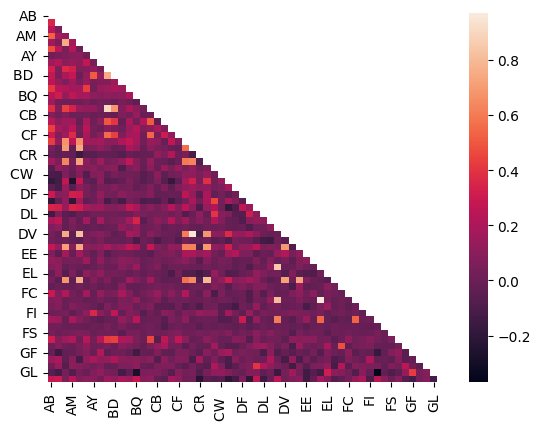

In [10]:
corr = train.corr()
# creating mask to remove upper right triangle
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask)

<Axes: >

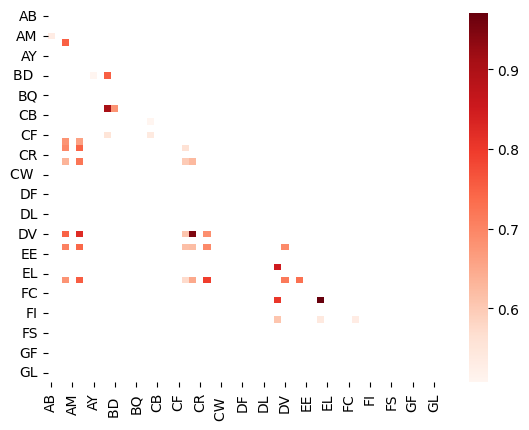

In [11]:
# filtring correlation values for highest (-+.5)
filtred_corr = corr[((corr >= .5) | (corr <= -.5)) & (corr !=1.000)]
sns.heatmap(filtred_corr, annot=False, cmap="Reds", mask=mask)

Very fiew hot spot of hight correlated (+/-) variables.

### Target Variable

In [12]:
# Balanced?
train['Class'].value_counts()

0    509
1    108
Name: Class, dtype: int64

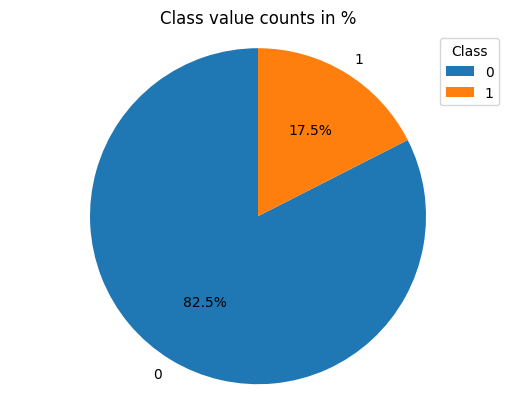

In [13]:
# code from matplotlib documentation to draw a pie chart

sizes = train['Class'].value_counts().to_list()
labels = train['Class'].value_counts().index.to_list()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.legend(title='Class')
ax1.set_title('Class value counts in %')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The target variable is imbalanced, with ratio of approx 1 to 5.

So, a data augmentation and/or balancing technique might be required in the modeling section.

## Greeks dataset

Ignored at this stage, as it will not be provided in the testing data.

# Preprocessing

## Missing Data

In [14]:
# Missing data counts
train.isna().sum()

AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [15]:
# Removing rows with missig data
train = train.dropna()

In [16]:
#  Sum of all missing values across variables
train.isna().sum().sum()

0

## Converting Categorical variables

In [17]:
# getting dummies for categorical variable
train.select_dtypes(exclude=['float64']).columns

Index(['EJ', 'Class'], dtype='object')

So, beside the [Id] and [Class] columns, we have one categorical variable called [EJ].

We use pandas' replace methods to 'Convert categorical variable into A:0/B:1 variables' as the docummentation suggest.


In [18]:
# A Glimpse into EJ variable
train['EJ'].value_counts()

B    329
A    219
Name: EJ, dtype: int64

In [19]:
# Conversion
train = train.replace({'EJ' : { 'A' : 0, 'B' : 1}})

In [20]:
train.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

The categorical variable in column 'EJ' are now converted into two numerical observations 0/1.

## Data Scaling

Different features with a variety of magnitudes expore our models (linear ones) to the risk of bias resulting from associating penality/importance to the order of magniture of each variable.

In [21]:
# Scaling train data into [0,1] range:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)

In [22]:
# Turning results into dataframe:
scaled_train = pd.DataFrame(scaled_train,
                            columns=train.columns)
scaled_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.028487,0.102347,0.000000,0.030632,0.000000,0.000000,0.000000,0.180337,0.002958,0.047364,...,0.051720,0.000998,0.000866,0.049385,0.000000,0.013846,0.176983,0.362261,0.005425,1.0
1,0.013752,0.027589,0.000000,0.053864,0.000000,0.078048,0.000000,0.284500,0.000000,0.074042,...,0.000000,0.000000,0.016014,0.033753,0.000000,0.194527,0.274495,0.164135,1.000000,0.0
2,0.088409,0.085715,0.000000,0.046519,0.000000,0.160575,0.000000,0.265013,0.000000,0.067011,...,0.054706,0.000385,0.036139,0.246003,0.011229,0.095035,0.258994,0.180218,0.008910,0.0
3,0.038310,0.127285,0.019180,0.117854,0.000000,0.079462,0.000000,0.215235,0.000000,0.048203,...,0.043183,0.000000,0.006925,0.104313,0.006882,0.014475,0.425143,0.470820,0.007039,0.0
4,0.067780,0.124246,0.000000,0.017417,0.000000,0.086300,0.002841,0.000000,0.069008,0.078555,...,0.057926,0.038597,0.001731,0.088112,0.051588,0.059198,0.500829,0.185841,0.004345,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,0.020629,0.084738,0.000000,0.006201,0.000000,0.088658,0.000000,0.000000,0.000000,0.098581,...,0.000000,0.001124,0.042415,0.091949,0.121764,0.076141,0.403292,0.210777,1.000000,0.0
544,0.014735,0.103085,0.021132,0.010101,0.028583,0.074511,0.005030,0.144730,0.001076,0.047970,...,0.000000,0.000614,0.000000,0.031266,0.101448,0.056218,0.211871,0.358883,1.000000,0.0
545,0.080550,0.184921,0.000000,0.069139,0.045868,0.140533,0.000030,0.259345,0.001742,0.077101,...,0.072953,0.000599,0.011469,0.236979,0.297867,0.021368,0.281649,0.651146,0.006562,0.0
546,0.078585,0.079539,0.024625,0.083174,0.010930,0.196180,0.000000,0.337644,0.000000,0.081672,...,0.000000,0.000000,0.000000,0.115256,0.039506,0.044942,0.233126,0.623561,1.000000,0.0


Now, we have training features with the same magnitudes (from 0 to 1). 

## Spliting training and testing sets

Setting 25% for testing and 75% for training.

In [23]:
# Define X and y
y = scaled_train['Class']
X = scaled_train.drop(columns='Class')

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state = random_state)

# Modeling Baseling

## SGDClassifier

In [39]:
# baseline model
SGDClassifier_model= SGDClassifier(loss='log_loss',
                                  penalty='l2', 
                                  alpha=0.0001, 
                                  l1_ratio=0.15, 
                                  fit_intercept=False, 
                                  max_iter=1000, 
                                  tol=0.001, 
                                  shuffle=True, 
                                  verbose=0, 
                                  epsilon=0.1, 
                                  n_jobs=-1, 
                                  random_state=random_state, 
                                  learning_rate='optimal', 
                                  eta0=0.0, 
                                  power_t=0.5, 
                                  early_stopping=False, 
                                  validation_fraction=0.30, 
                                  n_iter_no_change=10, 
                                  class_weight='balanced', # As our target var is imbalanced
                                  warm_start=False, 
                                  average=False)

SGDClassifier_model.fit(X_train, y_train)

SGDClassifier(class_weight='balanced', fit_intercept=False, loss='log_loss',
              n_iter_no_change=10, n_jobs=-1, random_state=88,
              validation_fraction=0.3)

## Results

In [40]:
# Training score
SGDClassifier_model.score(X_train, y_train)

0.927007299270073

In [41]:
pd.DataFrame(SGDClassifier_model.predict(X_train), columns=['Class']).value_counts()

Class
0.0      336
1.0       75
dtype: int64

In [42]:
# Testing score
SGDClassifier_model.score(X_test, y_test)

0.8686131386861314

In [43]:
pd.DataFrame(SGDClassifier_model.predict(X_test), columns=['Class']).value_counts()

Class
0.0      108
1.0       29
dtype: int64

In [44]:
# Testing probabilities
pd.DataFrame(SGDClassifier_model.predict_proba(X_test), 
             columns=['Class_0','Class_1']).round(4)

,Class_0,Class_1
0,0.9617,0.0383
1,0.9717,0.0283
2,0.8462,0.1538
3,0.9980,0.0020
4,0.8953,0.1047
...,...,...
132,0.9972,0.0028
133,0.9797,0.0203
134,0.8228,0.1772
135,0.9727,0.0273


In [ ]:
# Saving Model
pickle.dump(SGDClassifier_model, open('SGDClassifier_model.pkl', 'wb'))

#Optimized Models

In [ ]:
# Notes

# Kaggle Submission

## Code + Scores => Baseline Model

In [ ]:
# Libraries imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import pickle

#training 

train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv').set_index('Id')
## removing missing values
train = train.dropna()
## converting categorical variables
train = train.replace({'EJ' : { 'A' : 0, 'B' : 1}})
## Scaling
train =pd.DataFrame(MinMaxScaler().fit_transform(train), columns=train.columns)
## y
y = train['Class']
## X
X = train.drop(columns='Class')
## Predict_Prob
SGDClassifier_model= SGDClassifier(loss='log_loss',
                                  penalty='l1', 
                                  alpha=0.0001, 
                                  l1_ratio=0.15, 
                                  fit_intercept=False, 
                                  max_iter=1000, 
                                  tol=0.001, 
                                  shuffle=True, 
                                  verbose=0, 
                                  epsilon=0.1, 
                                  n_jobs=-1, 
                                  random_state=88, 
                                  learning_rate='optimal', 
                                  eta0=0.0, 
                                  power_t=0.5, 
                                  early_stopping=False, 
                                  validation_fraction=0.30, 
                                  n_iter_no_change=10, 
                                  class_weight='balanced', # As our target var is imbalanced
                                  warm_start=False, 
                                  average=False)

SGDClassifier_model.fit(X, y)

# Testing

test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv').set_index('Id')
## removing missing values
test = test.dropna()
## converting categorical variables
test = test.replace({'EJ' : { 'A' : 0, 'B' : 1}})
## Scaling
test =pd.DataFrame(MinMaxScaler().fit_transform(test), columns=test.columns)
## Creating Submission_file
submission = pd.DataFrame(SGDClassifier_model.predict_proba(test), 
                          columns=['class_0','class_1'])

submission.insert(0,
                  'Id',
                  pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv',
                  usecols=['Id']))

submission.to_csv('submission.csv', index=False)

In [ ]:
# score + ranking
'''
https://www.kaggle.com/code/mzaoualim/kaggle-icr
'''

# Conclusion

For future implementation, the following suggestions are to be considered for better scoring results:

1- Coding a customized loss function similar to the one targetted by the competition and train the model according to its outputs.

2- More sphistication with Data augmenting and balancing the target variable.

3- More attention to the 'greeks.csv' file.

4- Additionnal model can be considered in a stacking/voting architecture.

5- Experiment/finetunning the model(s) parameters.

6- More attention to the error/loss distributions.